# Setup

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from nltk.corpus import stopwords
import numpy as np
import os

pd.set_option('display.max_colwidth', None)

plt.rcParams['figure.dpi'] = 500

DATASET = 1

# Tokenisor Class

In [3]:
# Dataset class
class FinancialSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

In [4]:
# Load the dataset
df = pd.read_feather("../Data/Data1_NoClean.feather")

print(df.info())
print(df.sample(5))
print("\n", df['sentiment'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21365 entries, 0 to 21364
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           21365 non-null  object
 1   company_names  21365 non-null  object
 2   sentiment      21365 non-null  int64 
 3   base_url       21365 non-null  object
dtypes: int64(1), object(3)
memory usage: 667.8+ KB
None
                                                                                                                                               text  \
2762                                                                          $PEP $D $VINIX $VITSX $VIIIX $O $PM $SBUX $ED https://t.co/iU1fzyWHYY   
2021                                                    What’s Ahead for Ross Stores Inc $ROST After Less Shorted Shares? - https://t.co/sfs8vDWwFc   
11674                                         https://t.co/9VjKMnGXvX $ACXM $AL $BLUE $CPB $GDS $GOOS $GSH $ORIG $PGR $YRIV 

In [6]:
# Add additional stop words for financial context
stop_words_appended = stopwords.words('english')
stop_words_appended.extend(['rt', 'ep'])

# Model Initiliasation

In [7]:
# Check for model checkpoint
model_path = f'./Results/{DATASET}/checkpoint-21370'
if os.path.isdir(model_path):
    print("Loading model from checkpoint.")
    model = BertForSequenceClassification.from_pretrained(model_path)
else:
    print("No checkpoint found. Initializing from base model.")
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Loading model from checkpoint.


# Tokenisation

In [8]:
# Split the dataset
X = df[['text', 'base_url', 'company_names']].apply(lambda x: ' '.join(x), axis=1)
Y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = FinancialSentimentDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = FinancialSentimentDataset(X_test.tolist(), y_test.tolist(), tokenizer)

# Training

In [10]:
# Training arguments
training_args = TrainingArguments(
    output_dir=f'./Results/{DATASET}',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f'./Logs/{DATASET}',
    logging_steps=5,
    load_best_model_at_end=True,
    save_strategy="epoch",
    evaluation_strategy="epoch"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

if not os.path.exists(model_path):
    print("Starting training...")
    trainer.train()
else:
    print("Skipping training...")

/Users/josh/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping training...


In [11]:
# Evaluate
results = trainer.evaluate()
print("Evaluation results:", results)

  0%|          | 0/268 [00:00<?, ?it/s]

Evaluation results: {'eval_loss': 0.1487160623073578, 'eval_runtime': 78.7496, 'eval_samples_per_second': 54.261, 'eval_steps_per_second': 3.403}


In [12]:
# Print the log history to see what's being captured
print("Log history contents:")
for log in trainer.state.log_history:
    print(log)

Log history contents:
{'eval_loss': 0.1487160623073578, 'eval_runtime': 78.7496, 'eval_samples_per_second': 54.261, 'eval_steps_per_second': 3.403, 'step': 0}


In [ ]:
# Prepare data for plotting by converting it to a DataFrame
data = pd.DataFrame(trainer.state.log_history)

# Filter out rows where 'epoch' or 'loss' is missing
data = data.dropna(subset=['epoch', 'loss'])

# Set the seaborn theme
sns.set_theme(style="whitegrid")

# Create the plot with a figure size suitable for professional presentations
plt.figure(figsize=(12, 6))

# Plot the raw data points with transparency
sns.scatterplot(x='epoch', y='loss', data=data, alpha=0.04, label='Raw Data', color='blue')

# Calculate the rolling mean for a smooth trend line
rolling_mean = data['loss'].rolling(window=20).mean()

# Plot the trend line
plt.plot(data['epoch'], rolling_mean, color='red', label='Trend Line')

# Enhance the plot
plt.title('Model Loss over Epochs with Trend Line', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# Evaluation

  0%|          | 0/268 [00:00<?, ?it/s]

Accuracy: 0.8918792417505266


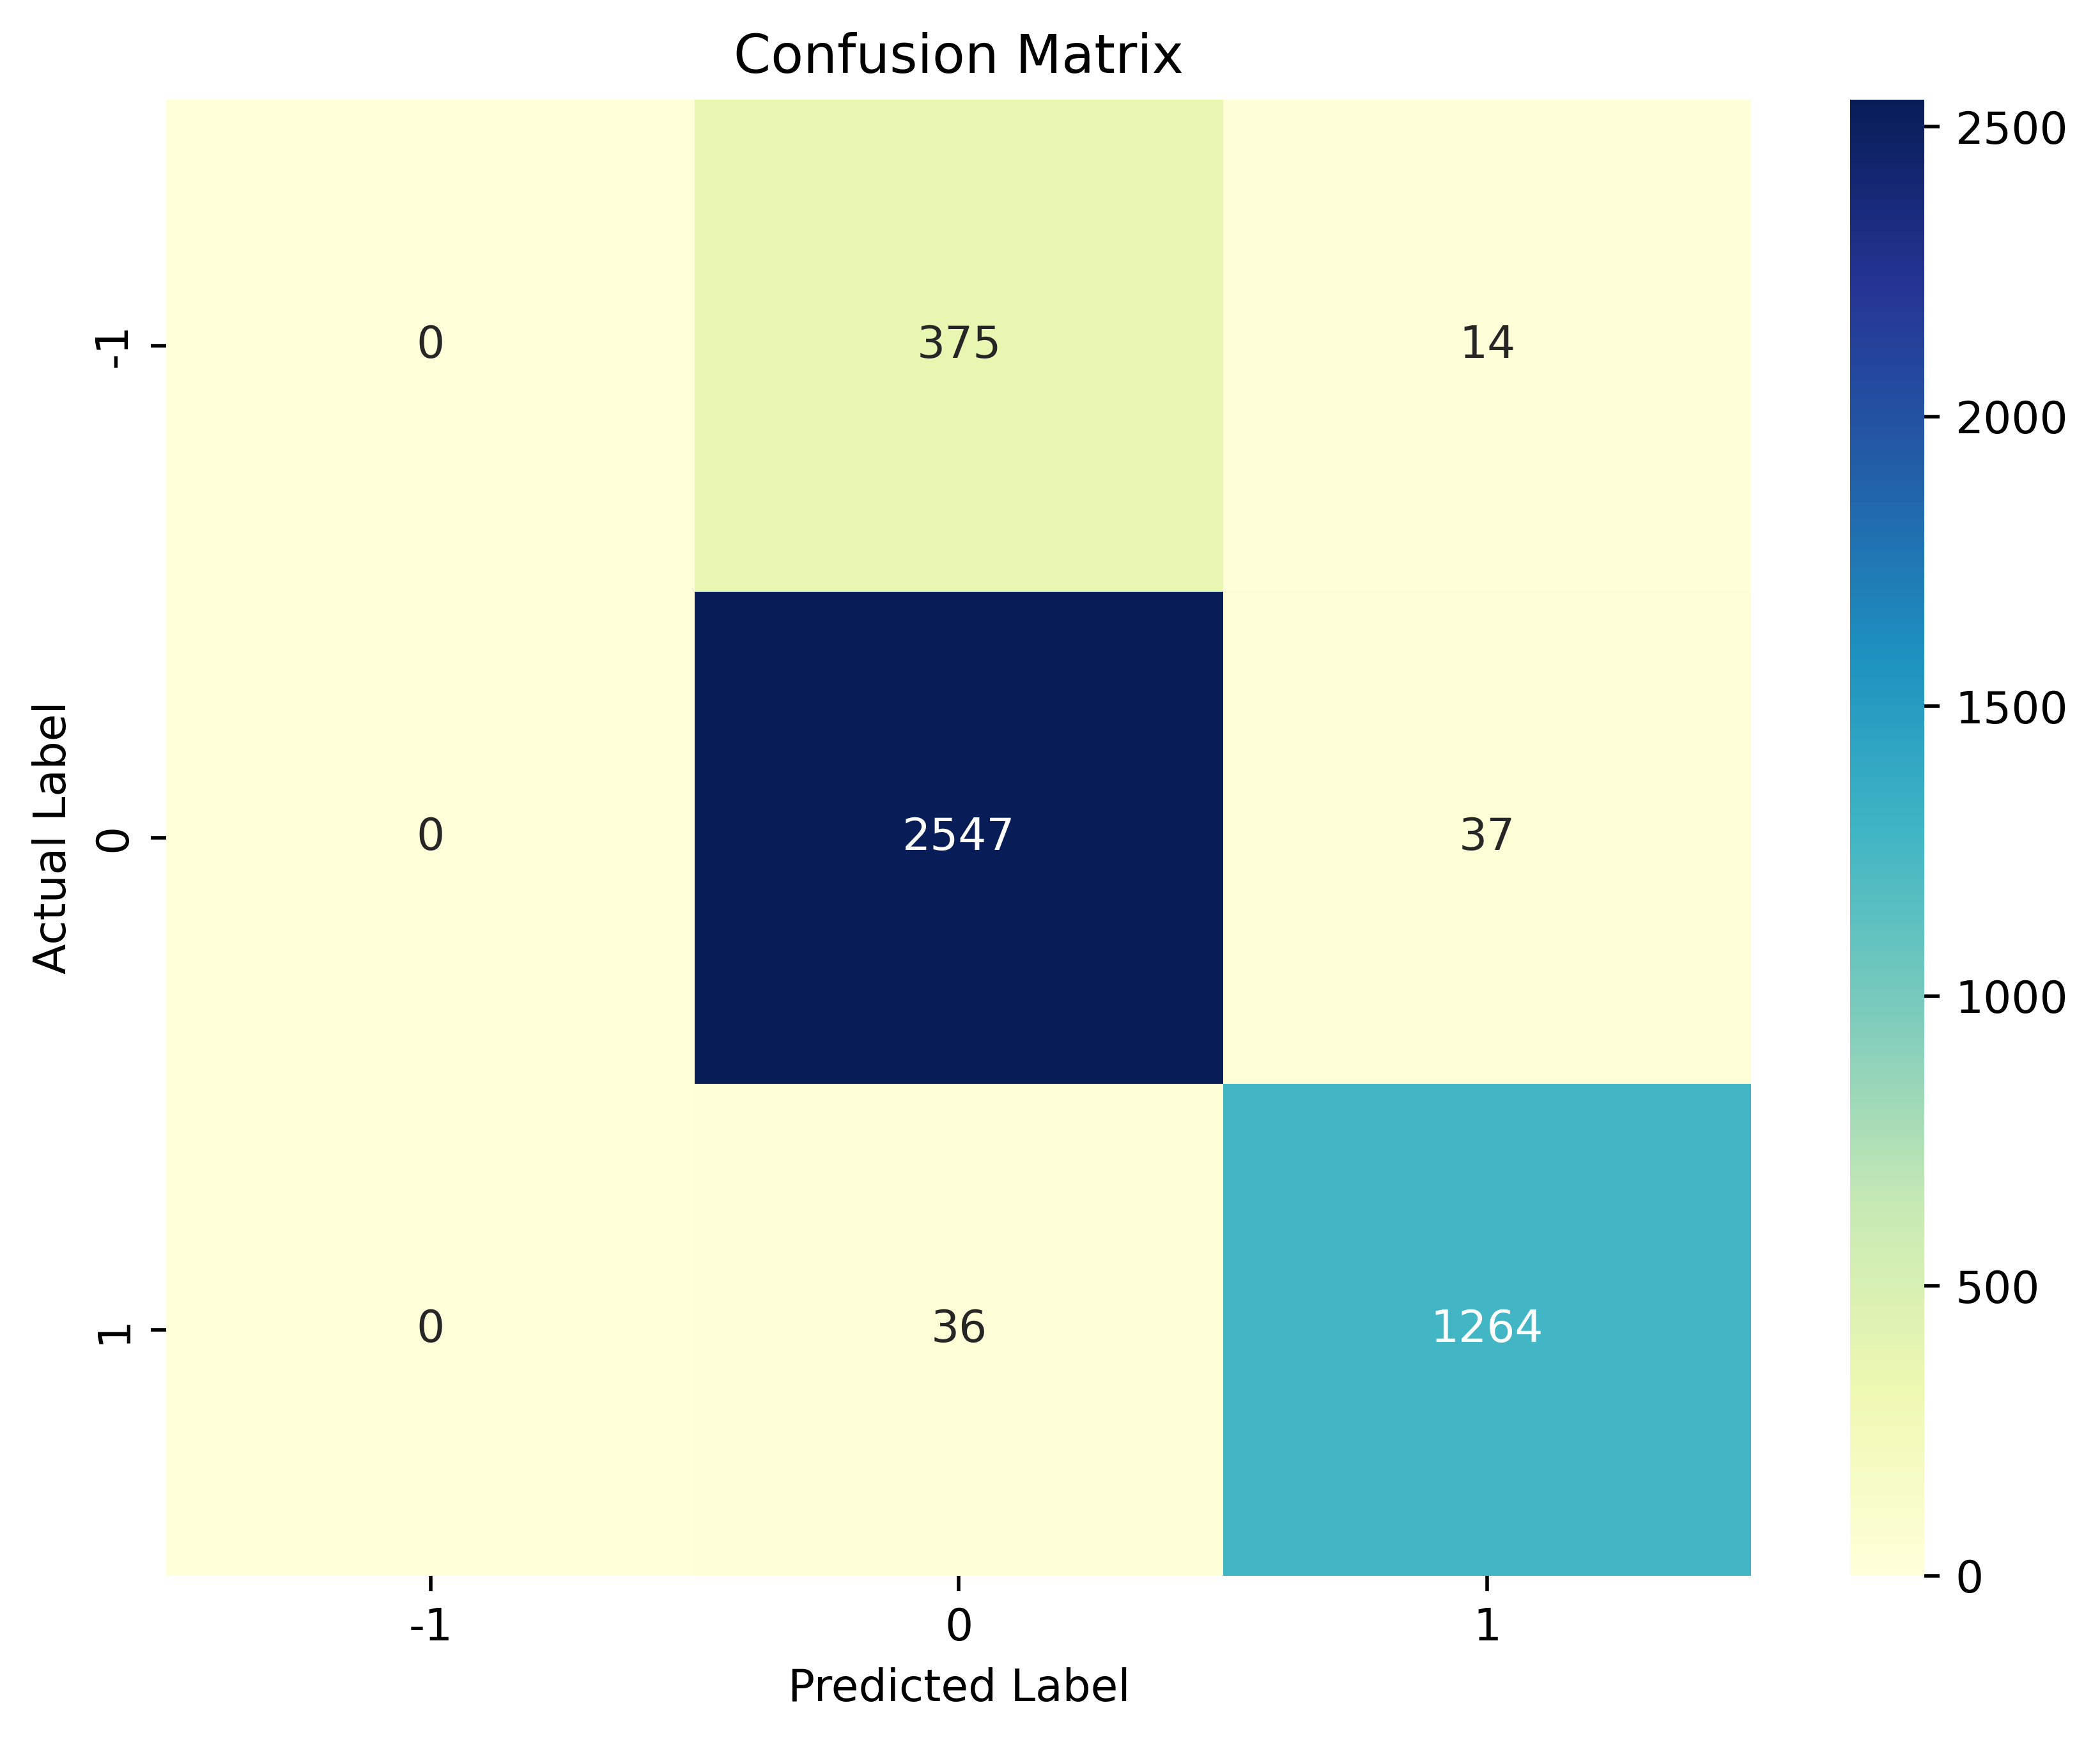

Confusion Matrix:
 [[   0  375   14]
 [   0 2547   37]
 [   0   36 1264]]


In [14]:
pred_labels = np.argmax(trainer.predict(test_dataset).predictions, axis=1)

original_labels = [-1, 0, 1]

# Print accuracy
print("Accuracy:", np.mean(pred_labels == y_test))

# Confusion Matrix
cm = confusion_matrix(y_test, pred_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu", xticklabels=original_labels, yticklabels=original_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Display the confusion matrix
print("Confusion Matrix:\n", cm)

In [15]:
# Classification Report
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       389
           0       0.86      0.99      0.92      2584
           1       0.96      0.97      0.97      1300

    accuracy                           0.89      4273
   macro avg       0.61      0.65      0.63      4273
weighted avg       0.81      0.89      0.85      4273



/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
